# Dst Forecasting via LSTM

In this notebook, I mirror the approach in the sister notebook [First Zonal Harmonic Forecasting via LSTM](forecasting_q10_LSTM.ipynb) to test the differences in forecasting between the two closely related time series. The Dst measurements come from the OMNI dataset, and all other input data are the same as from the sister notebook.

In [1]:
# general
import numpy as np
from sklearn import preprocessing
from scipy.stats import kde
from scipy import signal
import os
import datetime as dt
from helper_functions import *

# deep learning
import tensorflow as tf
from aux_keras import *

# file management, io
import pandas as pd
import h5py

# plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

Using TensorFlow backend.


## Load Data

Let's load the data without gaps as well as the external coefficients.

In [5]:
omni_lr = pd.read_hdf('omni_hourly_1998-2018_nogaps.h5')
dst = omni_lr['Dst-index, nT']
#omni_lr = omni_lr.drop('Dst-index, nT', axis=1)

nfeatin = omni_lr.shape[1]
ndat = omni_lr.shape[0]
t = np.linspace(1998, 2019, ndat+1)[0:-1]

The OMNI series are centered on the hour beginning at 0:00, but contain data averaged throughout the subsequent hour (i.e. hour 0 contains data averaged from 0:00-1:00). The data span from 0:00 January 1, 1998 to 23:00 December 31, 2017, UT. 

For now, I'll include previous values of Dst in the prediction, although ideally knowledge of the other variables would be sufficient to generate a successful model.

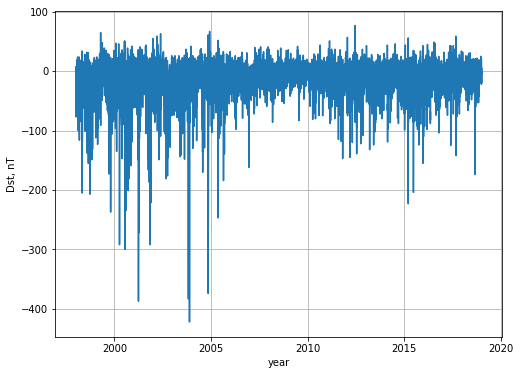

In [6]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(t,dst)
ax.set_ylabel('Dst, nT')
ax.set_xlabel('year')
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
plt.grid(True)
plt.show()

## LSTM with Keras
Having imported the data, let's design, train, and test the LSTM network for this prediction problem.

### Split and Prepare Data

Let's separate the data into training and testing sets. Let's also normalize all of the data according to the training data.

In [8]:
batch_size = 150
lahead = 6
train_percent = 0.8

In [9]:
# split
data_in_train, data_out_train, data_in_test, data_out_test = datasplit(omni_lr.values, dst.values.reshape(-1,1), batch_size, train_percent, lahead, stateful=True)

# normalize
scaler_input = preprocessing.MinMaxScaler(feature_range=(0,1))
data_in_train = scaler_input.fit_transform(data_in_train)
data_in_test = scaler_input.transform(data_in_test)

scaler_output = preprocessing.MinMaxScaler(feature_range=(0,1))
data_out_train = scaler_output.fit_transform(data_out_train)
data_out_test = scaler_output.transform(data_out_test)

# reshape input data
data_in_train = data_in_train.reshape(-1,1,nfeatin)
data_in_test = data_in_test.reshape(-1,1,nfeatin)

/Users/adrianraph/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [ ]:
rnn, hist = train_network(data_in_train, data_out_train, batch_size, epochs=100, stateful=True)
plt.plot(hist)

### Test

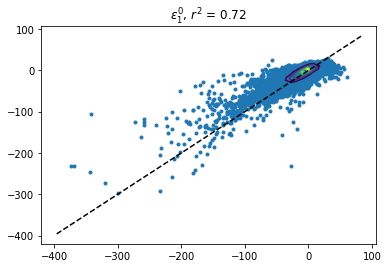

In [153]:
data_out_pred = test_network(data_in_test, data_out_test, rnn, batch_size,'$\epsilon_1^0$')

## LSTM with Torch

As for the $q_1^0$ forecasting, let's now practice with torch.

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1, num_layers=1):
        super(LSTM, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.output_dim = output_dim

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # we'll also need an output layer (equivalent of dense in keras)
        self.linear = nn.Linear(self.hidden_dim, self.output_dim)
        
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda(),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda())

    # number of input data must be divisible by batch_size
    def forward(self, input):
        self.hidden = self.init_hidden()
        lstm_out, self.hidden = self.lstm(input.view(-1, self.batch_size, self.input_dim), self.hidden)
        train_pred = self.linear(lstm_out)
        return train_pred

In [ ]:
# make training data into cuda tensors
data_in_train = torch.from_numpy(data_in_train).float().cuda()
data_out_train = torch.from_numpy(data_out_train).float().cuda()

# make testing data into cuda tensors
data_in_test = torch.from_numpy(data_in_test).float().cuda()
data_out_test = torch.from_numpy(data_out_test).float().cuda()

In [ ]:
hidden_dim = 20
batch_size = 500
num_layers = 1

model = LSTM(input_dim, hidden_dim, batch_size, output_dim, num_layers)

# run on gpu
model.cuda()

loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

nepochs = 20000
hist = np.zeros(nepochs)

for epoch in range(nepochs):
    optimizer.zero_grad()
    model.hidden = model.init_hidden()
    train_pred = model(data_in_train)
    loss = loss_function(train_pred, data_out_train.view(-1, batch_size, output_dim))
    
    hist[epoch] = loss.item()
    
    if epoch % 100 == 0:
        print('Epoch %d, MSE: %1.2e' % (epoch, loss.item()))
    
    loss.backward()
    optimizer.step()

plt.figure()
plt.plot(hist)
plt.show()

In [ ]:
model.hidden = model.init_hidden()
test_pred = model(data_in_test)
test_pred = test_pred.reshape(-1,1)

x = data_out_test.cpu().detach().numpy()
y = test_pred.cpu().detach().numpy()
plotcorr(x, y)

In [ ]:
plt.figure()
plt.plot(x, '.-')
plt.plot(y, '.--')
plt.show()

### Discuss

The best published result to date for t+6 prediction is that reported by Gruet et al. 2018, who achieve $R$=0.873 ($R^2$ = 0.762) on data from 2001-2016. This result is certainly an improvement over predicting by taking the last observed Dst value, whose correlation is then the hourly autocorrelation of lag 6 (the full autocorrelation function is shown below for various lags).

C:\Users\Adrian\.julia\packages\Conda\m7vem\deps\usr\lib\site-packages\scipy\signal\signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()
C:\Users\Adrian\.julia\packages\Conda\m7vem\deps\usr\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


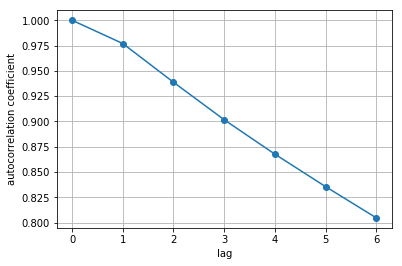

In [142]:
dstnorm = (dst-np.mean(dst))/np.std(dst)
dstcor = signal.correlate(dstnorm, dstnorm)/len(dstnorm)
idx = int(len(dstcor)/2)

plt.plot(dstcor[idx:idx+7],'o-')
plt.xlabel('lag')
plt.ylabel('autocorrelation coefficient')
plt.grid(True)

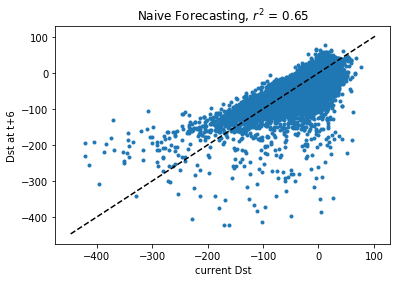

In [151]:
plt.scatter(dst[0:-6], dst[6:], marker='.')
abline(1, 0)
plt.xlabel('current Dst')
plt.ylabel('Dst at t+6')
plt.title('Naive Forecasting, $r^2$ = %1.2f' % dstcor[idx+6]**2)

plt.show()

In [ ]:
plotcorr(np.concatenate(dst))

Previous results tabulated (ADD TABLE) show that all neural networks except Gruet's and Wu & Lundstedt (1997) are unable (for t+6 prediction) to even replicate the results of the most basic prediction, which is to take the current value as a prediction for the value in 6 hours. This approach, as shown by the autocorrelation function, achieves $R$ = 0.804$, so to be considered an improvement over completely ignorant estimation, the neural network needs to achieve a higher correlation coefficient. 